In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
global_transformations = [oo.ImputationTransformer(),
                          oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                        custom_function=column_log),
                          oo.CenterScaleTransformer(),
                          oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

In [5]:
params_dict = dict(
                    min_child_weight=[1, 3, 5],
                    max_depth=[3, 5, 7, 9],
)
grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,min_child_weight,max_depth
0,1,3
1,1,5
2,1,7
3,1,9
4,3,3
5,3,5
6,3,7
7,3,9
8,5,3
9,5,5


In [6]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [7]:
hyper_param_object = oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.3,
                                n_estimators=1000,
                                max_depth=4,
                                min_child_weight=3,
                                gamma=0.1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight=scale_pos_weight_calc,)

In [8]:
model=oo.XGBoostClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_XGB'
resampler_cache_directory = 'tuner_XGB_resample_cache'

In [11]:
score_list = [BinaryAucRocScore(positive_class=positive_class, threshold=0.5),
              oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=score_list,
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      parallelization_cores=-1,  # Hyper-Parameter object specific to RF
                      #parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

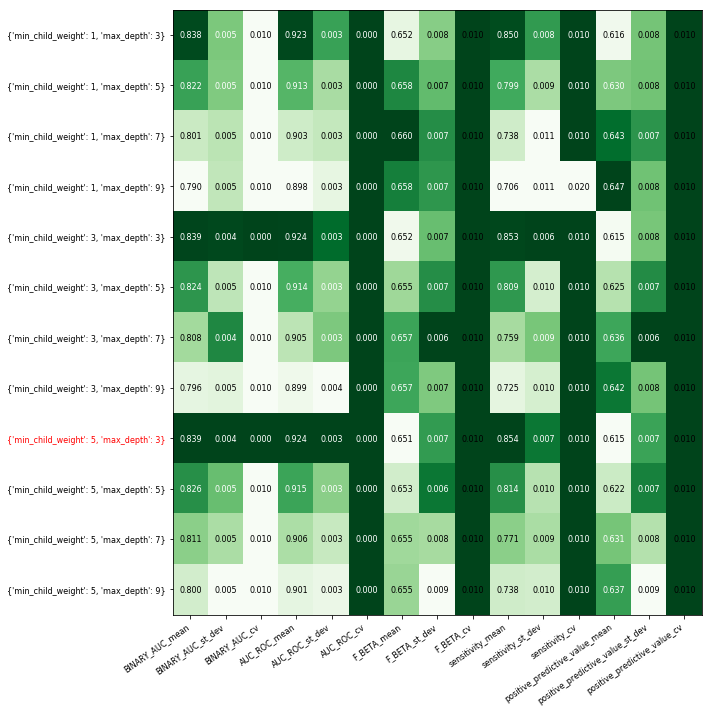

In [14]:
tuner.results.plot_resampled_stats()

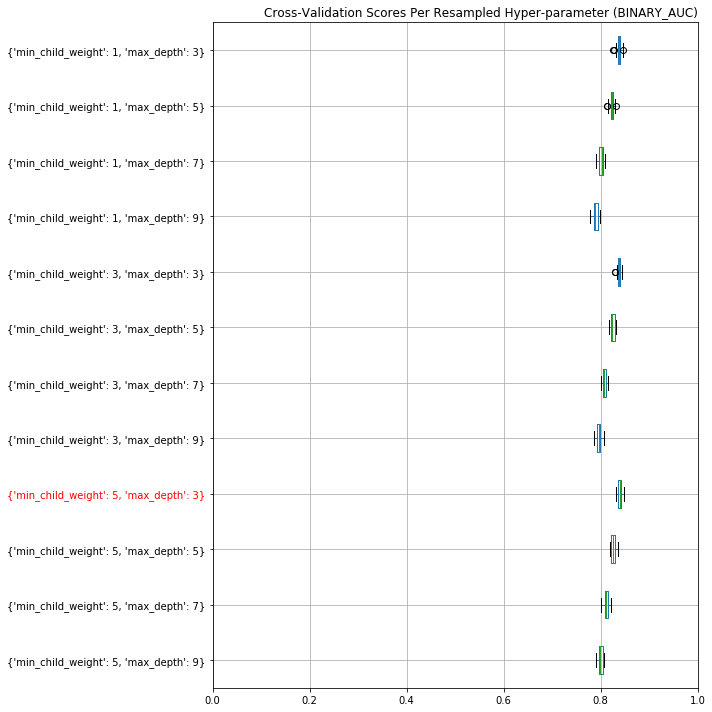

In [16]:
tuner.results.plot_resampled_scores(score_name='BINARY_AUC')